# Lecture 2.4: Lorenz System

The Lorenz system is a set of three coupled nonlinear ordinary differential equations that describe a simplified model of atmospheric convection. It was first introduced by Edward Lorenz in 1963 as a toy model for weather forecasting and later became famous for its chaotic behavior. The equations are given by:

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z,
\end{aligned}
$$

where $x$, $y$, and $z$ represent the state variables, $t$ is time, and $\sigma$, $\rho$, and $\beta$ are originally the heat transfer rate, the Rayleigh number, and the diffusion coefficient, respectively.
The system exhibits chaotic behavior for certain parameter values, leading to sensitive dependence on initial conditions and a butterfly effect. The Lorenz system has been used as a paradigmatic example of chaos in many fields, including physics, mathematics, and engineering.

The main idea of Lorenz System in the context of the Chaos Theory (that became famous through the butterfly effect quote), that even a deterministic model can be very impredictible due to its initial conditions, i.e., sensitive dependence on initial conditions.
This means that if we change the initial conditions by a very small amount, the system will behave completely different. This is the main idea of the butterfly effect.

The values $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$ are the canonical parameter values used in most literature and originally chosen by Edward Lorenz to lead a well-defined chaotic behavior. The system exhibits a butterfly-like shape from a certain angle, an icon which has been widely used in popular media to represent chaos.

### Importing the required libraries

In [1]:
from SALib.sample.sobol import sample
from SALib.analyze import sobol
from SALib import ProblemSpec
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


plt.rcParams["mathtext.fontset"] = "stix"

The `lorenz` function takes in the current time `t` and the current values of `x`, `y`, and `z` as `xyz`. It also has default values for the Lorenz system parameters: `sigma`, `rho`, and `beta`.

The function calculates the time derivatives of `x`, `y`, and `z` using the Lorenz system equations and returns them as a list.

The `solve_lorenz` function takes in the initial values of `x`, `y`, and `z` as `initial_xyz`, the time span to solve for as `t_span`, the number of time steps as `n_steps`, and any additional keyword arguments that can be passed to the `solve_ivp` function.

It generates an array of time points at which to evaluate the solution using `np.linspace`. The `solve_ivp` function is then called with the `lorenz` function, the time span, initial values, and the array of time points. The `dense_output=True` argument ensures that a callable function is returned as the solution, which can be used to evaluate the solution at any time point.

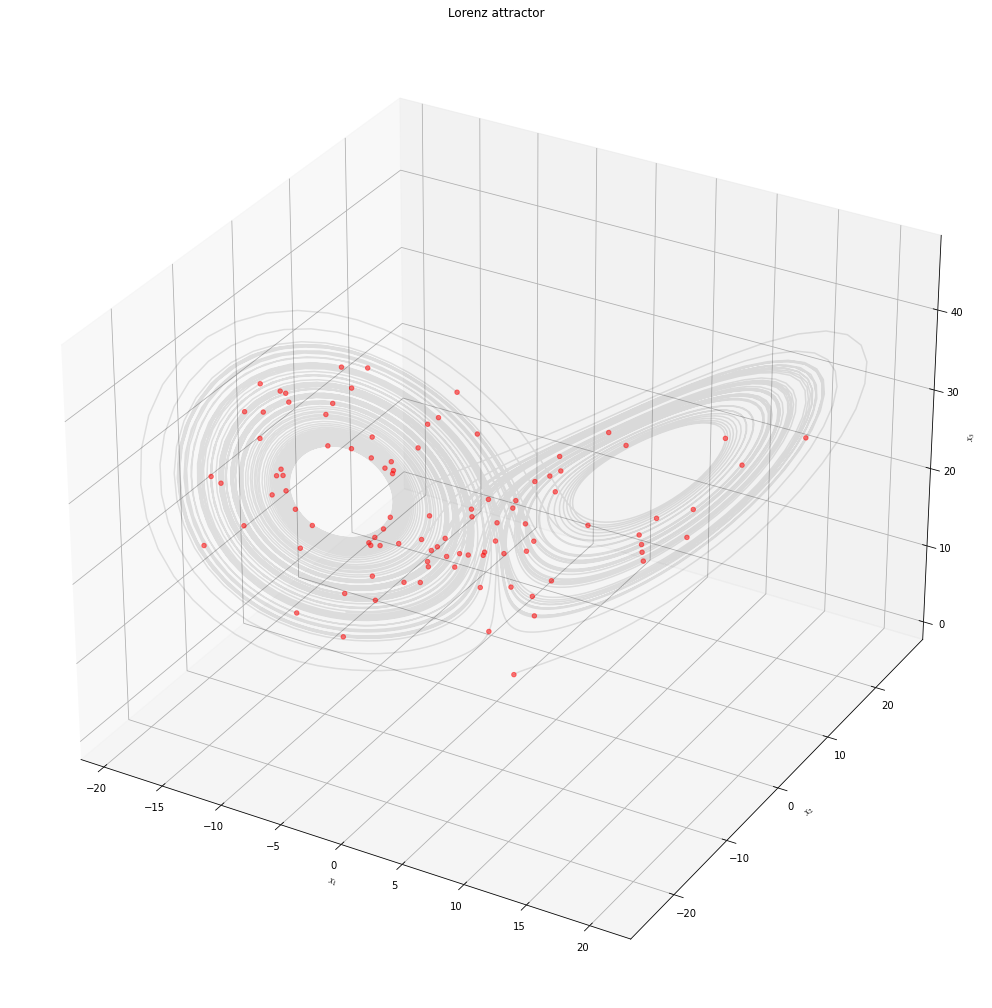

In [2]:
def lorenz(t, xyz, sigma=10, rho=28, beta=8/3):
    x, y, z = xyz
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

def solve_lorenz(initial_xyz, t_span=(0, 100), n_steps=10_000, sigma=10, rho=28, beta=8/3):
    t_eval = np.linspace(t_span[0], t_span[1], n_steps)
    sol = solve_ivp(lorenz, t_span, initial_xyz, t_eval=t_eval, dense_output=True, args=(sigma, rho, beta))
    return sol

def plot_lorenz_3d(sol, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(18, 18))
        ax = fig.add_subplot(111, projection='3d')
    ax.plot(sol.y[0], sol.y[1], sol.y[2], color='k', alpha=0.1)
    ax.scatter(sol.y[0][::100], sol.y[1][::100], sol.y[2][::100], color='r', alpha=0.5)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_zlabel("$x_3$")
    ax.set_title("Lorenz attractor")
    return ax

# test the function
sol = solve_lorenz([1, 1, 1], t_span=(0, 100), n_steps=10_000, sigma=13, rho=27, beta=3)
plot_lorenz_3d(sol)
plt.show()

Now, let's define our wrapped function to work with the sensitivity analysis.

In [3]:
def wrapped_lorenz(rv_params, xyz0=[1, 1, 1], t_span=(0, 10), n_steps=1_000):
    xyz = np.zeros((rv_params.shape[0], n_steps, 3))
    for i, (sigma, rho, beta) in enumerate(rv_params):
        sol = solve_lorenz(xyz0, t_span=t_span, n_steps=n_steps, sigma=sigma, rho=rho, beta=beta)
        xyz[i, :, :] = sol.y.T
    
    # reshape to (n_samples, n_steps * n_dim)
    xyz = xyz.reshape((rv_params.shape[0], -1))
    return xyz

## Sensitivity Analysis

### Defining the Analysis Problem

For this problem we gonna analyze the sensitivity of the output for two different set of parameters:
1. The hyperparameters of the model: $\sigma$, $\rho$, and $\beta$.
2. The initial conditions of the model: $x_0$, $y_0$, and $z_0$.

For both cases, we gonna use the canonical values used by Edward Lorenz to define an interval around them to perform the analysis.

So, let's start defining the first case.

In [4]:
# defining colors and latex symbols for plotting
colors = ['red', 'blue', 'green']
latex_symbols = {   'sigma': '\\sigma',
                    'rho': '\\rho',
                    'beta': '\\beta'
                    }

In [5]:
initial_xyz = [1, 1, 1]
t_span = (0, 5)
n_steps = 1_000

alpha = 0.1
problem = {
    'num_vars': 3,
    'names': ['sigma', 'rho', 'beta'],
    'bounds': [[10*(1-alpha), 10*(1+alpha)], [28*(1-alpha), 28*(1+alpha)], [8/3*(1-alpha), 8/3*(1+alpha)]] 
}

sp = ProblemSpec(problem)

n_samples = 2**10
sp.sample_sobol(n_samples) \
    .evaluate( lambda rv_params: wrapped_lorenz(rv_params, xyz0=initial_xyz, t_span=t_span, n_steps=n_steps) ) \
    .analyze_sobol()

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])
STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])

evaluations = sp.results

c:\Users\Lamap\anaconda3\lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


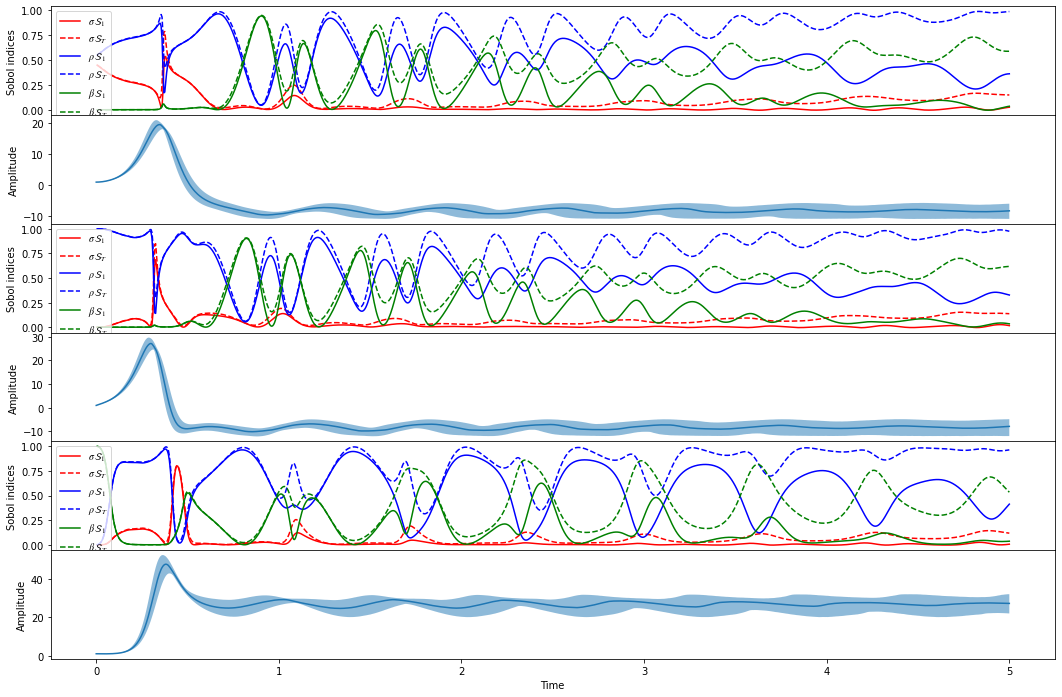

In [6]:
t = np.linspace(t_span[0], t_span[1], n_steps)

# reshape back to (n_samples, n_steps, n_dim)
evaluations = evaluations.reshape((-1, t.shape[0], 3))
S1s = S1s.reshape((t.shape[0], 3, 3))
STs = STs.reshape((t.shape[0], 3, 3))

fig, ax = plt.subplots(6, 1, sharex=True, figsize=(18, 12))
for dim in range(3):
    for i, key in enumerate(problem['names']):
        ax[2*dim].plot(t, S1s[:,dim,i], label=rf'${latex_symbols[key]}\, \mathcal{{S}}_1$', color=colors[i])
        ax[2*dim].plot(t, STs[:,dim,i], '--', label=rf'${latex_symbols[key]}\, \mathcal{{S}}_T$', color=colors[i])
    ax[2*dim].set_ylabel('Sobol indices')
    ax[2*dim].legend()

    median = np.median(   evaluations[:,:,dim], axis=0)
    upper = np.percentile(evaluations[:,:,dim], 95, axis=0)
    lower = np.percentile(evaluations[:,:,dim], 5, axis=0)
    ax[2*dim+1].plot(t, median, label='median')
    ax[2*dim+1].fill_between(t, lower, upper, alpha=0.5, label='95% confidence interval')
    ax[2*dim+1].set_xlabel('Time')
    ax[2*dim+1].set_ylabel(f'Position at $d={dim+1}$')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Now, let's define the second case.

In [7]:
def wrapped_lorenz_initial_point(rv_xyz, hyperparams=[10, 28, 8/3], t_span=(0, 10), n_steps=1_000):
    sigma, rho, beta = hyperparams
    xyz = np.zeros((rv_xyz.shape[0], n_steps, 3))
    
    for i, xyz0 in enumerate(rv_xyz):
        sol = solve_lorenz(xyz0, t_span=t_span, n_steps=n_steps, sigma=sigma, rho=rho, beta=beta)
        xyz[i, :, :] = sol.y.T
    
    # reshape to (n_samples, n_steps * n_dim)
    xyz = xyz.reshape((rv_xyz.shape[0], -1))
    return xyz

In [8]:
hyperparams = [10, 28, 8/3]
t_span = (0, 5)
n_steps = 5_000

problem_init = {
    'num_vars': 3,
    'names': ['x0', 'y0', 'z0'],
    'bounds': [[-0.9, 1.1]]*3
}

sp_init = ProblemSpec(problem_init)

n_samples = 2**10
sp_init.sample_sobol(n_samples) \
    .evaluate( lambda rv_xyz: wrapped_lorenz_initial_point(rv_xyz, hyperparams=hyperparams, t_span=t_span, n_steps=n_steps) ) \
    .analyze_sobol()

S1s = np.array([sp_init.analysis[_y]['S1'] for _y in sp_init['outputs']])
STs = np.array([sp_init.analysis[_y]['ST'] for _y in sp_init['outputs']])

evaluations = sp_init.results

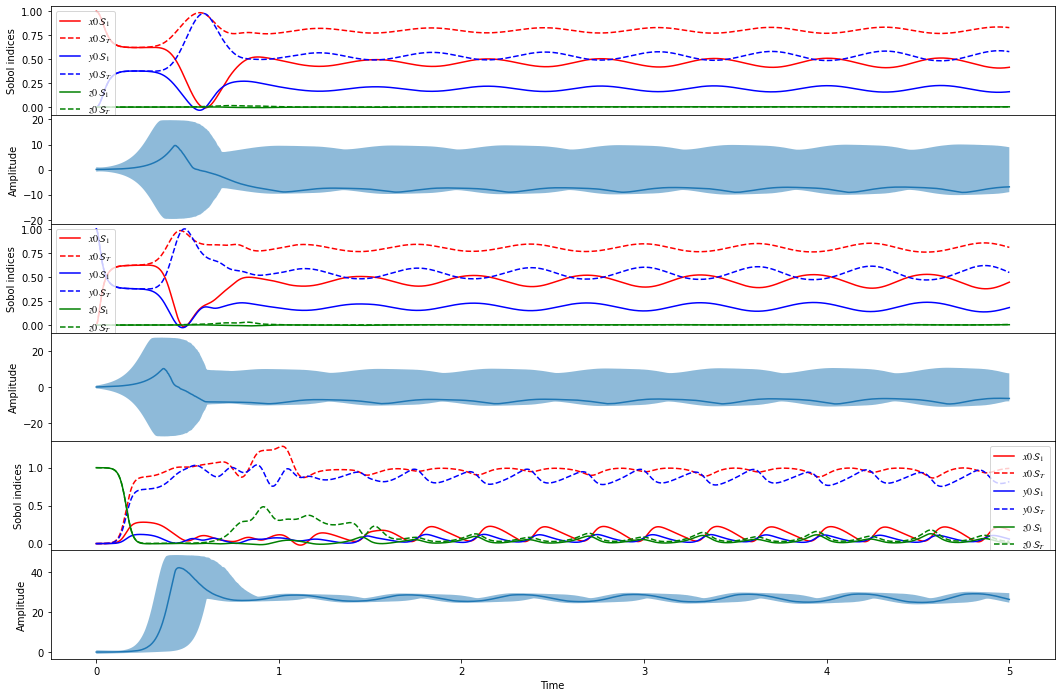

In [9]:
t = np.linspace(t_span[0], t_span[1], n_steps)

# reshape back to (n_samples, n_steps, n_dim)
evaluations = evaluations.reshape((-1, t.shape[0], 3))
S1s = S1s.reshape((t.shape[0], 3, 3))
STs = STs.reshape((t.shape[0], 3, 3))

fig, ax = plt.subplots(6, 1, sharex=True, figsize=(18, 12))
for dim in range(3):
    for i, key in enumerate(problem_init['names']):
        ax[2*dim].plot(t, S1s[:,dim,i], label=rf'${key}\, \mathcal{{S}}_1$', color=colors[i])
        ax[2*dim].plot(t, STs[:,dim,i], '--', label=rf'${key}\, \mathcal{{S}}_T$', color=colors[i])
    ax[2*dim].set_ylabel('Sobol indices')
    ax[2*dim].legend()

    median = np.median(   evaluations[:,:,dim], axis=0)
    upper = np.percentile(evaluations[:,:,dim], 95, axis=0)
    lower = np.percentile(evaluations[:,:,dim], 5, axis=0)
    ax[2*dim+1].plot(t, median, label='median')
    ax[2*dim+1].fill_between(t, lower, upper, alpha=0.5, label='95% confidence interval')
    ax[2*dim+1].set_xlabel('Time')
    ax[2*dim+1].set_ylabel(f'Position at $d={dim+1}$')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

We can see that...

___
We can still evaluate different inputs for the model, e.g. the final time the number of steps (which impacts the numeric method used to solve the ODE)

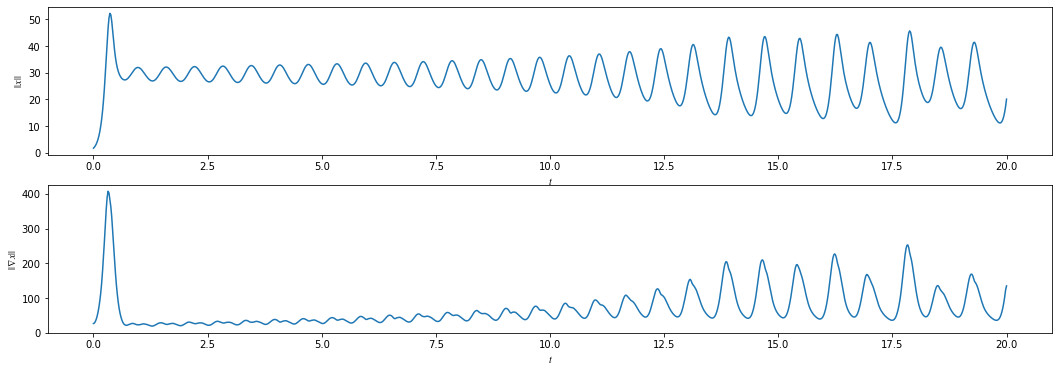

In [10]:
def get_norm(sol):
    return np.linalg.norm(sol.y, axis=0)

def get_norm_grad(sol):
    grad = np.gradient(sol.y, sol.t, axis=1)
    return np.linalg.norm(grad, axis=0)


sol = solve_lorenz([1, 1, 1], t_span=(0, 20), n_steps=1_000, sigma=10, rho=28, beta=8/3)

fig, ax = plt.subplots(2, 1, figsize=(18, 6))
ax[0].plot(sol.t, get_norm(sol))
ax[0].set_xlabel("$t$")
ax[0].set_ylabel("$||x||$")
# ax[0].set_title("Norm of the solution")
ax[1].plot(sol.t, get_norm_grad(sol))
ax[1].set_xlabel("$t$")
ax[1].set_ylabel("$||\\nabla x||$")
# ax[1].set_title("Norm of the gradient of the solution")
plt.show()

___
### References

[1] Lorenz, E. N. (1963). Deterministic nonperiodic flow. Journal of the atmospheric sciences, 20(2), 130-141. [doi:10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2)